Task 4 The NISQ devices

Generate the SWAP Test of the following states:

$$\begin{pmatrix}\sqrt{0.3}\\\sqrt{0.7}\end{pmatrix},\begin{pmatrix}\sqrt{0.6}\\\sqrt{0.4}\end{pmatrix}$$
$$\begin{pmatrix}\sqrt{0.1}\\\sqrt{0.2}\\\sqrt{0.6}\\\sqrt{0.1}\end{pmatrix},
\begin{pmatrix}\sqrt{0.0}\\\sqrt{0.5}\\\sqrt{0.1}\\\sqrt{0.4}\end{pmatrix}$$
$$\begin{pmatrix}\sqrt{0.01}\\\sqrt{0.10}\\\sqrt{0.12}\\\sqrt{0.13}\\\sqrt{0.04}\\\sqrt{0.00}\\\sqrt{0.35}\\\sqrt{0.25}\end{pmatrix},
\begin{pmatrix}\sqrt{0.00}\\\sqrt{0.20}\\\sqrt{0.20}\\\sqrt{0.10}\\\sqrt{0.20}\\\sqrt{0.05}\\\sqrt{0.05}\\\sqrt{0.20}\end{pmatrix}$$

and apply a depolarization in a qubit gate error from 0.01 to 0.50, you consider step size and evaluate, explain the limit, capabilities or improvements that the computer has, make plots, number of gates, identify in your view what the limiting factor is and how it can be improved if so.

In [1]:
from qiskit import *
import numpy as np
from qiskit.tools.monitor import job_monitor
from qiskit_aer import AerSimulator

First we create a function that generates the correct swap-test circuit for any two input state. We begin by initialising the first $2n$ qubits in the QuantumRegister to match the probability amplitudes described by the input size vectors $\ket{\alpha}$ and $\ket{\beta}$. Here $n$ corresponds to $log_2(dim(\vec{s_1}))$, we check that $\vec{s1}$ and $\vec{s2}$ are the same and that the input state vectors are valid.

To perform the SWAP test, we apply the hadamard gate to an ancillary qubit to project it into the equal superposition state, the resuliting circuit state is thus: $$\frac{1}{\sqrt{2}}(\ket{0,\alpha,\beta}+\ket{1,\alpha,\beta})$$

Applying a multi-gate cSWAP then yields a circuit state of:
$$\frac{1}{\sqrt{2}}(\ket{0,\alpha,\beta}+\ket{1,\beta,\alpha})$$

Re-application of the hadamard gate to the ancillary qubit yields:
$$\frac{1}{2}\left[\ket{0}(\ket{\alpha,\beta}+\ket{\beta,\alpha})+\ket{1}(\ket{\alpha,\beta}-\ket{\beta,\alpha})\right]$$

In [2]:
def gen_qc(state1:np.ndarray,
           state2:np.ndarray):

    if state1.size != state2.size:
        print("Array's representing states must be of same size!")
        return False

    if np.log2(state1.size) % 1:
        print("Input state is invalid!")
        return False

    if int(sum(state1**2)) != 1 or int(sum(state2**2)) != 1:
        print("Input state is invalid!")
        return False

    num_qubits = int(np.log2(state1.size))

    s1 = QuantumRegister(num_qubits,'state1')
    s2 = QuantumRegister(num_qubits,'state2')
    cr = QuantumRegister(1,'ancilla')
    cbit = ClassicalRegister(1)

    qc = QuantumCircuit(s1,s2,cr,cbit)
    qc.initialize(state1,s1)
    qc.initialize(state2,s2)

    qc.h(cr)
    for i in range(int(np.log2(state1.size))):
        qc.cswap(cr,s1[i],s2[i])
    qc.h(cr)

    qc.measure(cr,cbit)

    return qc  

By taking repeated shots and approximating the probabilty of measuring the ancillary qubit is $\ket{0}$ as the proportion of counts. As we know that the probability of measuring the state $\ket{1}$ is:

$$P(1) = \frac{1}{2}(1-|\braket{\alpha|\beta}|^2)$$

We can approximate the inner product of the two input vectors as:
$$|\braket{\alpha|\beta}|^2 = 1-\frac{2*numShots_b}{numShots}$$

In [3]:
backend_sim = Aer.get_backend('qasm_simulator')
def compute_SQP(qc):  
    nShots = 1024
    job_sim = backend_sim.run(transpile(qc, backend_sim), shots=nShots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts()
    try:
        b = counts['1']
    except:
        b = 0
    return 1-(2/nShots)*(b),counts

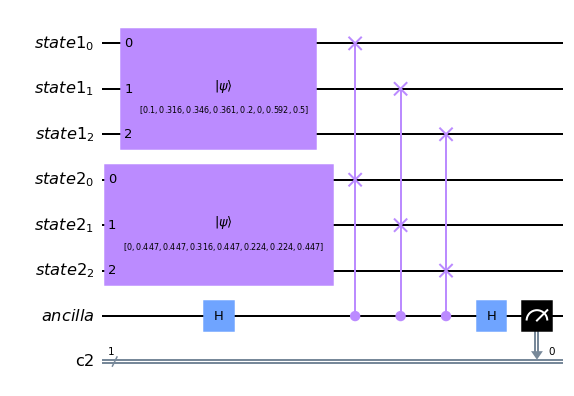

In [4]:
state1 = [np.array([np.sqrt(0.3),np.sqrt(0.7)]),
      np.array([np.sqrt(0.1),np.sqrt(0.2),np.sqrt(0.6),np.sqrt(0.1)]),
      np.array([np.sqrt(0.01),np.sqrt(0.10),np.sqrt(0.12),np.sqrt(0.13),np.sqrt(0.04),np.sqrt(0.0),np.sqrt(0.35),np.sqrt(0.25)])]
      
state2 = [np.array([np.sqrt(0.6),np.sqrt(0.4)]),
      np.array([np.sqrt(0.0),np.sqrt(0.5),np.sqrt(0.1),np.sqrt(0.4)]),
      np.array([np.sqrt(0.0),np.sqrt(0.20),np.sqrt(0.20),np.sqrt(0.10),np.sqrt(0.20),np.sqrt(0.05),np.sqrt(0.05),np.sqrt(0.20)])]

qc1,qc2,qc3 = (gen_qc(s1,s2) for s1, s2 in zip(state1,state2))
# qc1.draw(output='mpl')
# qc2.draw(output='mpl')
qc3.draw(output='mpl')

In [5]:
print(f'''
-------------------------------------------------------------------------
The inner product of the first pair of states is : {compute_SQP(qc1)[0]}
-------------------------------------------------------------------------
The inner product of the second pair of states is : {compute_SQP(qc2)[0]}
-------------------------------------------------------------------------
The inner product of the third pair of states is : {compute_SQP(qc3)[0]}
-------------------------------------------------------------------------
''')


-------------------------------------------------------------------------
The inner product of the first pair of states is : 0.900390625
-------------------------------------------------------------------------
The inner product of the second pair of states is : 0.591796875
-------------------------------------------------------------------------
The inner product of the third pair of states is : 0.74609375
-------------------------------------------------------------------------



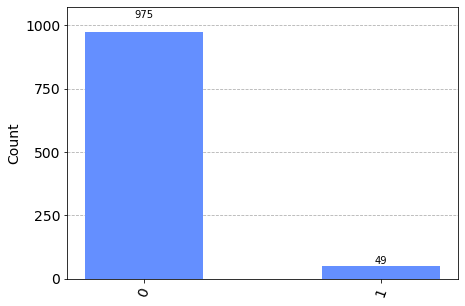

In [6]:
from qiskit.visualization import plot_histogram
plot_histogram(compute_SQP(qc1)[1])

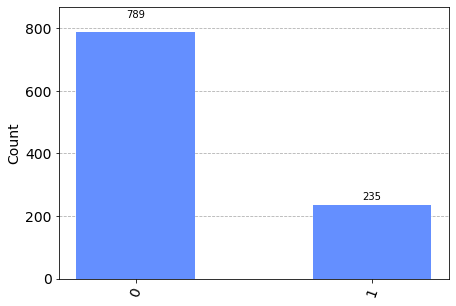

In [7]:
plot_histogram(compute_SQP(qc2)[1])

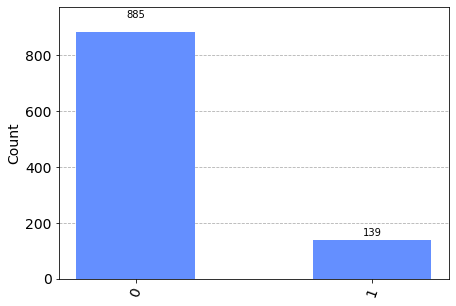

In [8]:
plot_histogram(compute_SQP(qc3)[1])

The SWAP test algorithm is a simple low depth algorithm that would be suitable to run on a Near-term Intermediate Scale Quantum (NISQ) device. Despite this current NISQ devices are susceptible do a littany of errors. One classification of an error are incoherent errors which can be understood as errors that entangle the system with its environment or coherent errors with randomly varying control parameters.

A simple model to implement incoherent noise into our system is the depolarizing noise model:$$\epsilon(\rho)=(1-\lambda)\rho+\lambda Tr[\rho]\frac{I}{2^n}$$

Where $\rho$ is the density matrix which describes the quantum state of our system and $\lambda$ is the depolarization parameter that is dependent on the type of device used to perform the algorithm, n is simply the number of qubits.

For this algorithm all the input states are pure states such that $Tr[\rho]$ is always 1. Moreover for $n=1$ there are three, non-trivial, gates that can be applied a.k.a the Pauli gates. The corresponding single qubit polarization channel is mapped to by the mapping:$$f:\lambda\rightarrow P$$ $$\lambda = \frac{4P}{3}$$

This is all applied using the noise model functionality in qiskit and is run on all unitaries of dimension $1$, $2$, and $3$.

In [9]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
def create_noise(p:float=0.01,n:int=1):
    noise_model = NoiseModel()
    error = depolarizing_error(4*p/3, n)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    return noise_model, error

In [10]:
nm, dep_err = create_noise()
print(dep_err)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.9900000000000001, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
  P(1) = 0.003333333333333334, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(2) = 0.003333333333333334, Circuit = 
   ┌───┐
q: ┤ Y ├
   └───┘
  P(3) = 0.003333333333333334, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘


In [11]:
nm, dep_err = create_noise(0.5)
print(dep_err)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.5000000000000001, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
  P(1) = 0.16666666666666669, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(2) = 0.16666666666666669, Circuit = 
   ┌───┐
q: ┤ Y ├
   └───┘
  P(3) = 0.16666666666666669, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘


Observe that the probability of applying a non-identity gate is 0.01 and 0.5 respecitively, as expected!

Let's now test the model on the single qubit state swap test pair, we expect that the higher noise model probability should deviate further from the expected inner product

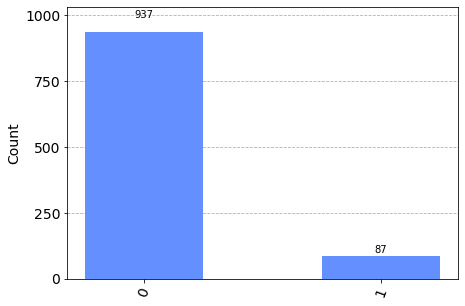

In [12]:
sim_noise = AerSimulator(noise_model=create_noise(0.01)[0])
job_sim = sim_noise.run(transpile(qc1, sim_noise),
                        shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts()
plot_histogram(counts)

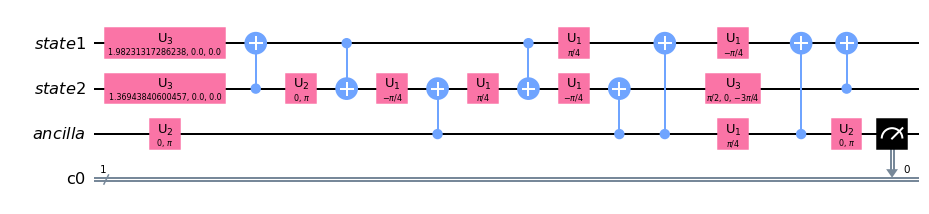

In [13]:
sim_noise = AerSimulator(noise_model=create_noise(0.5)[0])
job_sim = sim_noise.run(transpile(qc1, sim_noise),
                        shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts()
plot_histogram(counts)
transpile(qc1, sim_noise).draw(output='mpl')

As expected the model with more noise disrupted the results more... how does this vary between different initial states and are there tabulated values for incoherent noise for different NISQ devices?

In [14]:
def compute_SQP_noisy(qc,noise):
    nshots = 1024
    sim_noise = AerSimulator(noise_model=create_noise(noise)[0])
    job_sim = sim_noise.run(transpile(qc1, sim_noise),
                            shots=nshots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts()
    try:
        b = counts['1']
    except:
        b = 0
    return 1-(2/nshots)*(b)

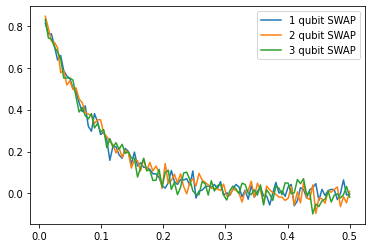

In [15]:
import matplotlib.pyplot as plt

p =  np.linspace(0.01,0.5,100)
res1, res2, res3 = ([compute_SQP_noisy(qc, noise) for noise in p] for qc in [qc1,qc2,qc3])
plt.plot(p,res1,label='1 qubit SWAP')
plt.plot(p,res2,label='2 qubit SWAP')
plt.plot(p,res3,label='3 qubit SWAP')
plt.legend()

The graph clealy indicates the size of the multi qubit SWAP test does not influence the effect of decoherent noise. The interesting feature of this graph is that the effect of noise appears to be converge to around $0.87$ at $p = 0.5$. This is likely a consequence of the inherent nature of a depolarizing channel, the depolarizing channel maps our state $\rho$ to a linear combination of itself and the maximally mixed state. At $p = 0.5$ the state is mapped mostly to the maximally mixed state and so it is independant of the input state $\rho$.